In [1]:
from pathlib import Path
import pandas as pd
import json
import joblib
import requests
import matplotlib.pyplot as plt
import re
import unicodedata
import inflect
infl = inflect.engine()

In [2]:
pd.set_option("display.max_columns",None)

### Raw Data Import and Dataset Build

In [3]:
DATA = Path("dataset").resolve()
TEST_DF = Path("scratch_work_files").resolve()

In [4]:
# # Load only the first 10,000 reviews for testing
# reviews = []
# businesses = []
# with open(DATA / "yelp_academic_dataset_review.json", "r") as f1:
#     for i, line in enumerate(f1):
#         if i >= 250000:
#             break
#         reviews.append(json.loads(line))

# with open(DATA / "yelp_academic_dataset_business.json","r") as f2:
#     for i, line in enumerate(f2):
#         if i >= 250000:
#             break
#         businesses.append(json.loads(line))

# reviews_df = pd.merge(
#   pd.DataFrame(reviews),
#   pd.DataFrame(businesses),
#   how = "inner",
#   on = "business_id",
#   suffixes = ["_review","_restaurant"]
#   ).dropna()

# joblib.dump(reviews_df,TEST_DF / "review_testing_data.pkl")


In [5]:
reviews_df_complete = joblib.load(TEST_DF / "review_testing_data.pkl")

In [6]:
reviews_df_complete = pd.merge(
    reviews_df_complete,
    reviews_df_complete.groupby("business_id")["stars_review"].mean().rename("avg_stars"),
    how = "inner",
    on = "business_id"
)

In [7]:
cond1 = reviews_df_complete["categories"].str.lower().str.contains("restaurants")
cond2 = reviews_df_complete["categories"].str.lower().str.contains("hotels")
cond3 = reviews_df_complete["avg_stars"] < 4
reviews_df_complete = reviews_df_complete[
    (cond1) 
    & (~cond2)
#    & (cond3)
]

In [8]:
review_counts = reviews_df_complete.groupby("business_id")["review_id"].count().rename("total_reviews")
sample_id = review_counts[review_counts.between(100,200)].sample(3).index.tolist()

In [9]:
reviews_df = reviews_df_complete.copy()[reviews_df_complete["business_id"].isin(sample_id)]
reviews_df = reviews_df[["business_id","name","text"]].sort_values(by = "name").reset_index(drop = True)

In [10]:
reviews_df = pd.merge(reviews_df,review_counts,how = "inner",on = "business_id").drop('business_id',axis = 1)

### Function Builds

In [11]:
def CleanReviewText(text):
    """
    Removes & and nonstandard ascii characters to make the LLM's interpretation job easier
    """

    if not isinstance(text, str):
        return ""

    # Normalize Unicode (e.g., é → e)
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")

    # Replace ampersands with "and" when used as a connector
    text = re.sub(r'\s*&\s*', ' and ', text)

    # Replace all forms of whitespace (tabs, newlines, multiple spaces) with a single space
    text = re.sub(r'\s+', ' ', text)

    # Trim leading/trailing whitespace
    return text.strip()


reviews_df["text"] = reviews_df["text"].apply(CleanReviewText)

In [12]:
def FormatClassList(values, max_items=None):
    """
    Transform the list of classes into different phrasings in natural English.
    Useful for dynamically passing possible classes to the prompt.
    """
    if max_items:
        values = values[:max_items]
    
    if not values:
        return ""
    elif len(values) == 1:
        return values[0]
    elif len(values) == 2:
        return f"{values[0]} and {values[1]}"
    else:
        return ", ".join(values[:-1]) + f", and {values[-1]}"

In [13]:
def BuildPrompt(business_name,classes,reprocess = False):
    """
    Build the prompt that will be passed to the LLM.
    Using a function allows the prompt to be printed and previewed.
    """

    prompt = f"""
You are a restaurant review classifier that is reviewing {business_name}.
Given a review of {business_name}, classify the reviewer's attitude toward three key aspects: food and drinks (including prices), service, and ambiance.
Return a JSON-style matrix in this form: {{"food": "[class]", "service": "[class]", "ambiance": "[class]"}}.
For [class], return one of {infl.number_to_words(len(valid_classes))} possible values: {FormatClassList(classes)}.
{FormatClassList(classes[:-1])} are classifications of the reviewer's feelings toward their experience.
Return "{FormatClassList(classes[-1:])}" if the reviewer does not address a certain aspect of the experience.
Here is an example review: "The appetizers at this place were phenomenal, but the margaritas were overpriced and watery. Service was HORRENDOUS."
In this example, return: {{"food": "{classes[1]}", "service": "{classes[2]}", "ambiance": "{classes[3]}"}}.
Here is another example: "Our server was outstanding and the entrees were perfectly cooked. We loved the decor, too!"
In this example, return: {{"food": "{classes[0]}", "service": "{classes[0]}", "ambiance": "{classes[0]}"}}.
No other output is desired.
    """
    if reprocess == True:
        prompt += f"""
Please focus on selecting a class from these values: {FormatClassList(classes)}. 
Other class choices, even if more descriptive, are not helpful in this instance.
If the reviewer has mixed opinions (a combination of positive, disappointed, and/or angry) about an aspect of their experience, bias toward the negative; 
that is, classify according to the more negative statements and choose "{valid_classes[0]}" only if the review is solely comprised of positive statements.
        """

    return prompt

In [14]:
def ClassifyReview(review_text, business_name, classes, model='mistral',reprocess = False):
    """
    Build the prompt and pass to the LLM for evaluation.
    """

    url = "http://localhost:11434/api/chat"
    headers = {"Content-Type": "application/json"}
      
    data = {
        "model": model,
        "messages": [
            {
                "role": "system",
                "content": BuildPrompt(business_name,classes,reprocess) 
            },
            {
                "role": "user",
                "content": review_text
            }
        ],
        "stream": False
    }

    response = requests.post(url, json=data, headers=headers)
    return response.json()["message"]["content"]


In [15]:
def ParseReviewAnalyticsOutput(text):
    """
    Parses potentially messy JSON-like LLM output by:
    - Truncating after the first closing brace
    - Quoting unquoted keys
    - Quoting unquoted string values
    - Removing parenthetical commentary from values
    - Falling back to regex if JSON parsing fails
    Returns a dictionary with aspect classifications.
    """
    # Step 0: Truncate at first closing brace to avoid trailing commentary
    text = text.strip()
    closing_brace_index = text.find("}")
    if closing_brace_index != -1:
        text = text[:closing_brace_index + 1]

    # Step 0b: Remove parenthetical notes from values (e.g., "none (but blah)" -> "none")
    text = re.sub(r'"\s*([^"]*?)\s*\([^"]*\)"', r'"\1"', text)

    # Step 1: Fix unquoted keys
    text = re.sub(r'([{,]\s*)(\w+)(\s*:)', r'\1"\2"\3', text)

    # Step 2: Fix unquoted string values (assume words are categorical, not numbers or booleans)
    text = re.sub(r':\s*([a-zA-Z_]+)(\s*[,}])', r': "\1"\2', text)

    # Try JSON parsing
    try:
        parsed = json.loads(text)
        return {
            "food": parsed.get("food", "none").split()[0].lower(),
            "service": parsed.get("service", "none").split()[0].lower(),
            "ambiance": parsed.get("ambiance", "none").split()[0].lower()
        }
    except Exception:
        pass  # fallback to regex next

    # Fallback regex-based parsing
    result = {"food": "none", "service": "none", "ambiance": "none"}
    for aspect in ["food", "service", "ambiance"]:
        match = re.search(rf'{aspect}\s*[:=]\s*["\']?(\w+)', text, re.IGNORECASE)
        if match:
            result[aspect] = match.group(1).lower()

    return result


In [16]:
def GenerateReprocessData(df,classes):
    invalid_food = ~df["food"].isin(classes)
    invalid_service = ~df["service"].isin(classes)
    invalid_ambiance = ~df["ambiance"].isin(classes)

    to_reprocess = df[invalid_food | invalid_service | invalid_ambiance]
    df = df.drop(labels = to_reprocess.index)
    to_reprocess = to_reprocess.reset_index(drop=True)
    return df,to_reprocess

### Review Evaluation Config

In [17]:
valid_classes = ["positive","disappointed","angry","none"]
print(BuildPrompt(business_name="{restaurant name}",classes=valid_classes,reprocess=True))


You are a restaurant review classifier that is reviewing {restaurant name}.
Given a review of {restaurant name}, classify the reviewer's attitude toward three key aspects: food and drinks (including prices), service, and ambiance.
Return a JSON-style matrix in this form: {"food": "[class]", "service": "[class]", "ambiance": "[class]"}.
For [class], return one of four possible values: positive, disappointed, angry, and none.
positive, disappointed, and angry are classifications of the reviewer's feelings toward their experience.
Return "none" if the reviewer does not address a certain aspect of the experience.
Here is an example review: "The appetizers at this place were phenomenal, but the margaritas were overpriced and watery. Service was HORRENDOUS."
In this example, return: {"food": "disappointed", "service": "angry", "ambiance": "none"}.
Here is another example: "Our server was outstanding and the entrees were perfectly cooked. We loved the decor, too!"
In this example, return: {"

### Process Analytics

In [18]:
%%time

result_list = []
for review in reviews_df.itertuples():
    result = ClassifyReview(review.text,business_name=review.name,classes=valid_classes,reprocess = False)
    result_list.append(result)

CPU times: user 1.67 s, sys: 409 ms, total: 2.08 s
Wall time: 12min 55s


In [19]:
result_df = pd.concat([reviews_df,(pd.DataFrame(pd.Series(result_list).apply(ParseReviewAnalyticsOutput).tolist()))],axis = 1)

In [20]:
# result_df["check_col"] = (
# result_df["food"].str.strip().str.lower()
# + result_df["service"].str.strip().str.lower()
# + result_df["ambiance"].str.strip().str.lower()
# )

# result_df[result_df["check_col"] == "nonenonenone"]

### Reprocess Analytics for Noncompliant Rows

In [21]:
# from random import randint
# counter = 0
# while counter < 5:
#     result_df.loc[randint(0,99),["food"]] = "N/A"
#     result_df.loc[randint(0,99),["ambiance"]] = "N/A"
#     result_df.loc[randint(0,99),["service"]] = "N/A"
#     counter +=1


In [22]:
# "neutral" is a common hallucination that the LLM has; this is best replaced with "none" to save reprocessing compute
result_df = result_df.replace(to_replace="neutral",value="none")

In [23]:
result_df,to_reprocess = GenerateReprocessData(result_df,valid_classes)

repr_stage1_invalid = to_reprocess[["food","service","ambiance"]].size - to_reprocess[["food","service","ambiance"]].isin(valid_classes).sum().sum()

In [24]:
%%time

repr_result_list = []
for review_repr in to_reprocess.itertuples():
    repr_result = ClassifyReview(review_repr.text,business_name=review_repr.name,classes=valid_classes,reprocess = True)
    repr_result_list.append(repr_result)

CPU times: user 6.8 ms, sys: 2.28 ms, total: 9.08 ms
Wall time: 4.12 s


In [25]:
to_reprocess_again = pd.concat([to_reprocess[["name","text","total_reviews"]],(pd.DataFrame(pd.Series(repr_result_list).apply(ParseReviewAnalyticsOutput).tolist()))],axis = 1)

repr_stage2_invalid = to_reprocess_again[["food","service","ambiance"]].size - to_reprocess_again[["food","service","ambiance"]].isin(valid_classes).sum().sum()

### Final Reprocess Cycle: Replace Noncompliant Rows With 'none'

In [26]:
reprocessed = to_reprocess_again.copy()
if reprocessed.shape[0] > 0:
    reprocessed.loc[~reprocessed["food"].isin(valid_classes),["food"]] = "none"
    reprocessed.loc[~reprocessed["service"].isin(valid_classes),["service"]] = "none"
    reprocessed.loc[~reprocessed["ambiance"].isin(valid_classes),["ambiance"]] = "none"


In [27]:
result_df = pd.concat([result_df,reprocessed],axis = 0).reset_index(drop = True)

### Load Result DF Here

In [28]:
# import joblib
# import pandas as pd
# import matplotlib.pyplot as plt

# # joblib.dump(result_df,"scratch_work_files/results_sample.pkl")
# # joblib.dump(to_reprocess,"scratch_work_files/pre_reprocess_dataframe.pkl")
# # joblib.dump(reprocessed,"scratch_work_files/post_reprocess_dataframe.pkl")

# result_df = joblib.load("scratch_work_files/results_sample.pkl")
# to_reprocess = joblib.load("scratch_work_files/pre_reprocess_dataframe.pkl")
# reprocessed = joblib.load("scratch_work_files/post_reprocess_dataframe.pkl")

### Plot Analysis Results

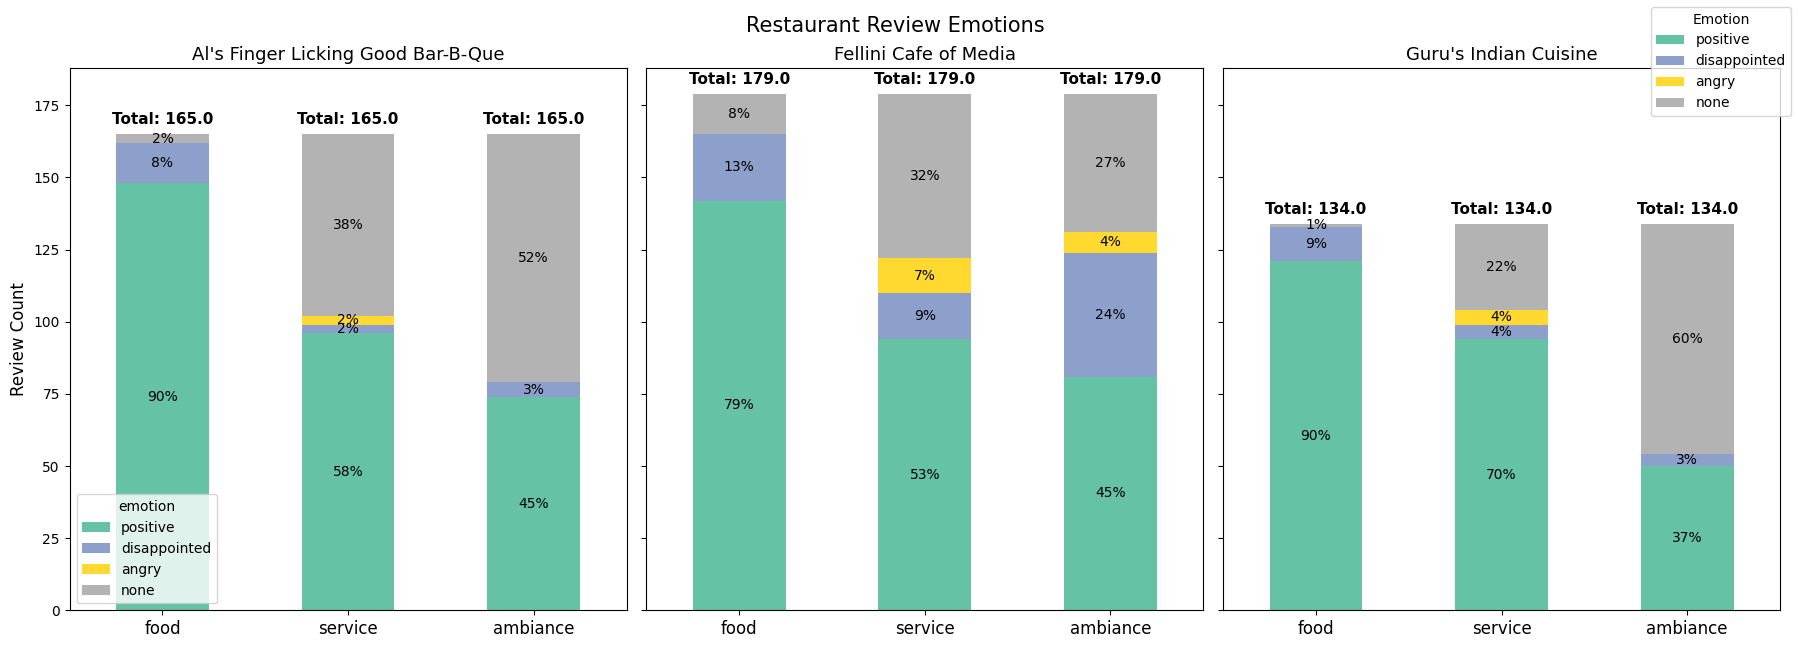

In [29]:
# 1. Melt into long format
melted = result_df.melt(
    id_vars="name",
    value_vars=["food", "service", "ambiance"],
    var_name="aspect",
    value_name="emotion"
)

# 2. Count occurrences
counts = (
    melted.groupby(["name", "aspect", "emotion"])
    .size()
    .reset_index(name="count")
)

# 3. Pivot for stacked bars
pivoted = counts.pivot_table(
    index=["name", "aspect"],
    columns="emotion",
    values="count",
    fill_value=0
)

# Ensure consistent emotion order
emotion_order = ["positive", "disappointed", "angry", "none"]
pivoted = pivoted.reindex(columns=emotion_order, fill_value=0)

# 4. Add row totals for percentage & total labels
pivoted["total"] = pivoted.sum(axis=1)

# 5. Create subplots
restaurants = pivoted.index.get_level_values(0).unique()
n_restaurants = len(restaurants)

fig, axes = plt.subplots(1, n_restaurants, figsize=(6 * n_restaurants, 6.5), sharey=True)

if n_restaurants == 1:
    axes = [axes]

for ax, restaurant in zip(axes, restaurants):
    group = pivoted.loc[restaurant]
    group_no_total = group.drop(columns="total")
    group_no_total.index = pd.Categorical(group_no_total.index,categories=["food","service","ambiance"],ordered=True)
    group_no_total = group_no_total.sort_index()

    # Plot stacked bars
    group_no_total.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        colormap="Set2",
        legend=(ax == axes[0])
    )
    ax.set_title(restaurant,fontsize = 13)
    ax.set_ylabel("Review Count",fontsize = 12)
    # ax.set_xlabel("Aspect",fontsize = 12)
    ax.tick_params(axis="x", rotation=0,labelsize = 12)


        # annotate percentages
    for container in ax.containers:
        for rect in container:
            height = rect.get_height()
            if height > 0:
                total_height = group["total"].values[0]
                percentage = 100 * height / total_height
                ax.annotate(f"{percentage:.0f}%",
                            xy=(rect.get_x() + rect.get_width() / 2,
                                rect.get_y() + height / 2),
                            ha="center", va="center", fontsize=10, color="black")

    # Add total count labels above bars
    for idx, (aspect, row) in enumerate(group.iterrows()):
        total = row["total"]
        ax.annotate(f"Total: {total}",
                    xy=(idx, total),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=11, fontweight="bold")

# Legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Emotion", loc="upper right")


plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.suptitle("Restaurant Review Emotions",fontsize = 15)
plt.show()

### Generate Reprocessing Statistics (How Often the LLM Provides And INvalid Class)

In [35]:
print("Initial Results Needing Reprocessing")
display(to_reprocess)
print("Reprocessed Results Needing a Second Reprocessing")
display(to_reprocess_again)

Initial Results Needing Reprocessing


,name,text,total_reviews,food,service,ambiance
0,Fellini Cafe of Media,Casual italian fare in a happy environment. Th...,179,mixed,none,positive
1,Fellini Cafe of Media,Update: after going here a few more times I ha...,179,mixed,none,mixed


Reprocessed Results Needing a Second Reprocessing


,name,text,total_reviews,food,service,ambiance
0,Fellini Cafe of Media,Casual italian fare in a happy environment. Th...,179,mixed,none,positive
1,Fellini Cafe of Media,Update: after going here a few more times I ha...,179,mixed,none,disappointed


In [33]:
repr_stats_df = pd.DataFrame({
"valid":[result_df.size - repr_stage2_invalid,result_df.size - repr_stage1_invalid],
"invalid":[repr_stage2_invalid,repr_stage1_invalid],
},index =["after first reprocessing","initial pass"]
)


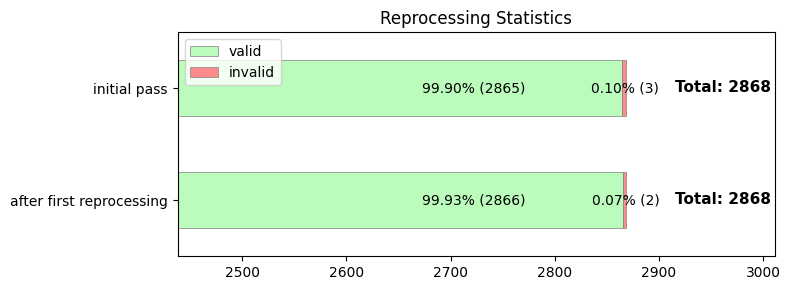

In [34]:
fig,ax = plt.subplots(1,1,figsize = (8,3))

color_map = {"valid":"#BBFCBC","invalid":"#FD8B8B"}
repr_stats_df.plot(
    kind = "barh",
    stacked = True,
    ax = ax,
    color = [color_map[col] for col in repr_stats_df.columns],
    edgecolor = "gray",
    linewidth = 0.5
)
                   
ax.set_xlim([result_df.size*0.85,result_df.size*1.05])
ax.set_title("Reprocessing Statistics")

# annotate percentages
for container in ax.containers:
    for rect in container:
        width = rect.get_width()
        if width > 0:
            percentage = 100 * width / result_df.size
            ax.annotate(f"{percentage:.2f}% ({width:.0f})",
                        xy=(rect.get_x() + width*0.95,
                            rect.get_y() + rect.get_height() / 2),
                        ha="center", va="center", fontsize=10, color="black")

for idx,row in enumerate(repr_stats_df.itertuples()):
    total = row.valid + row.invalid
    ax.annotate(f"Total: {total}",
                xy=(total,idx),
                xytext=(70, -5),
                textcoords="offset points",
                ha="center", va="bottom", fontsize=11, fontweight="bold")
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title ="", loc="upper left")
plt.tight_layout()